# Overview
The notebook is mainly done for my own benefit to better understand what graph convolutional networks do on a very basic and visual task (MNIST). 

The notebook is just a slightly more visual version of the MNIST example provided at https://github.com/danielegrattarola/spektral/blob/master/examples/graph_signal_classification_mnist.py as part of the [Spektral](https://github.com/danielegrattarola/spektral) package. 

## Install Dependencies

In [1]:
!apt-get install -y graphviz libgraphviz-dev libcgraph6




graphviz is already the newest version (2.38.0-17).
libcgraph6 is already the newest version (2.38.0-17).
libcgraph6 set to manually installed.
The following additional packages will be installed:
  autotools-dev libexpat1 libexpat1-dev libgvc6-plugins-gtk libltdl-dev
  libtool
Suggested packages:
  libtool-doc autoconf automaken gcj-jdk
The following NEW packages will be installed:
  autotools-dev libexpat1-dev libgraphviz-dev libgvc6-plugins-gtk libltdl-dev
  libtool
The following packages will be upgraded:
  libexpat1
1 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 1156 kB of archives.
After this operation, 3598 kB of additional disk space will be used.
Get:1 http://security.debian.org/debian-security stretch/updates/main amd64 libexpat1 amd64 2.2.0-2+deb9u3 [83.7 kB]
Get:2 http://deb.debian.org/debian stretch/main amd64 autotools-dev all 20161112.1 [73.4 kB]
Get:3 http://security.debian.org/debian-security stretch/updates/main amd64 libexpat1-dev amd6

In [2]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-kh7t4s8_
  Running command git clone -q https://github.com/danielegrattarola/spektral /tmp/pip-req-build-kh7t4s8_
     |████████████████████████████████| 337kB 2.9MB/s 
     |████████████████████████████████| 412.3MB 25kB/s 
     |████████████████████████████████| 122kB 35.8MB/s 
     |████████████████████████████████| 512kB 29.6MB/s 
     |████████████████████████████████| 3.8MB 33.3MB/s 
  Created wheel for spektral: filename=spektral-0.1.1-cp36-none-any.whl size=62419 sha256=50d6ccaf7d8ca3cb9380f5c4c4419cd604659802454bc540b4ced9ef4d7bfa83
  Stored in directory: /tmp/pip-ephem-wheel-cache-ufcteyio/wheels/bb/69/6d/48b6769ec1ce561cb3e97aaca871070b0b3bea51c4341aebe2
  Created wheel for pygraphviz: filename=pygraphviz-1.5-cp36-cp36m-linux_x86_64.whl size=192000 sha256=985bfa747916bdb5d702aaeecb028506a60d85c7f678977bcb6d70fa5af89657
  Stored in directory: /tmp/.cache/pip/wheels/65/54/69/1aee9e66ab19916293208d4c9

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
import networkx as nx
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, arrows=True, ax=ax)
    ax.autoscale()
    return fig, ax, pos

## Libraries
Here are the libraries and imports to make the model

In [4]:
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

Using TensorFlow backend.


In [5]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32       # Batch size
epochs = 5        # Number of training epochs
es_patience = 200     # Patience fot early stopping

In [6]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test, adj = mnist.load_data()
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10  # Dimension of the target

print(X_train.shape, 'model input')

11493376/11490434 [==============================] - 0s 0us/step
(50000, 784, 1) model input


## Goal
The goal of the problem is to correctly classify the digits using the intensity values as the nodes and the neighborhood relationships as the edges. When we visualize the adjacency matrix we can see the effect of a simply unraveled 2D array

(784, 784) adjacency matrix


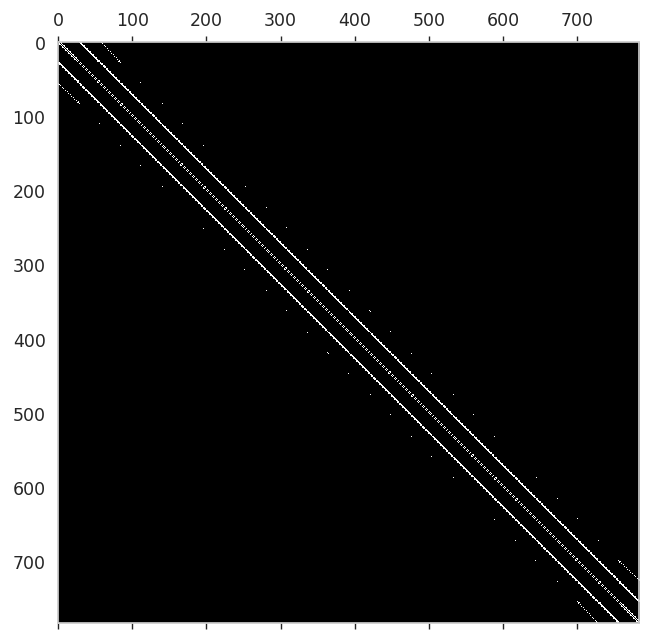

In [7]:
print(adj.shape, 'adjacency matrix')
plt.matshow(adj.todense())

### Label Nodes and Show Connections
Here we can visualize the topology a bit better and see what the graph actually looks like.

In [8]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

In [9]:
print(node_id[300], 'is connected to')
for row, col in zip(*adj[300].nonzero()):
    print(col, '->', node_id[col])

X:20_Y:10 is connected to
271 -> X:19_Y:09
272 -> X:20_Y:09
273 -> X:21_Y:09
299 -> X:19_Y:10
301 -> X:21_Y:10
327 -> X:19_Y:11
328 -> X:20_Y:11
329 -> X:21_Y:11


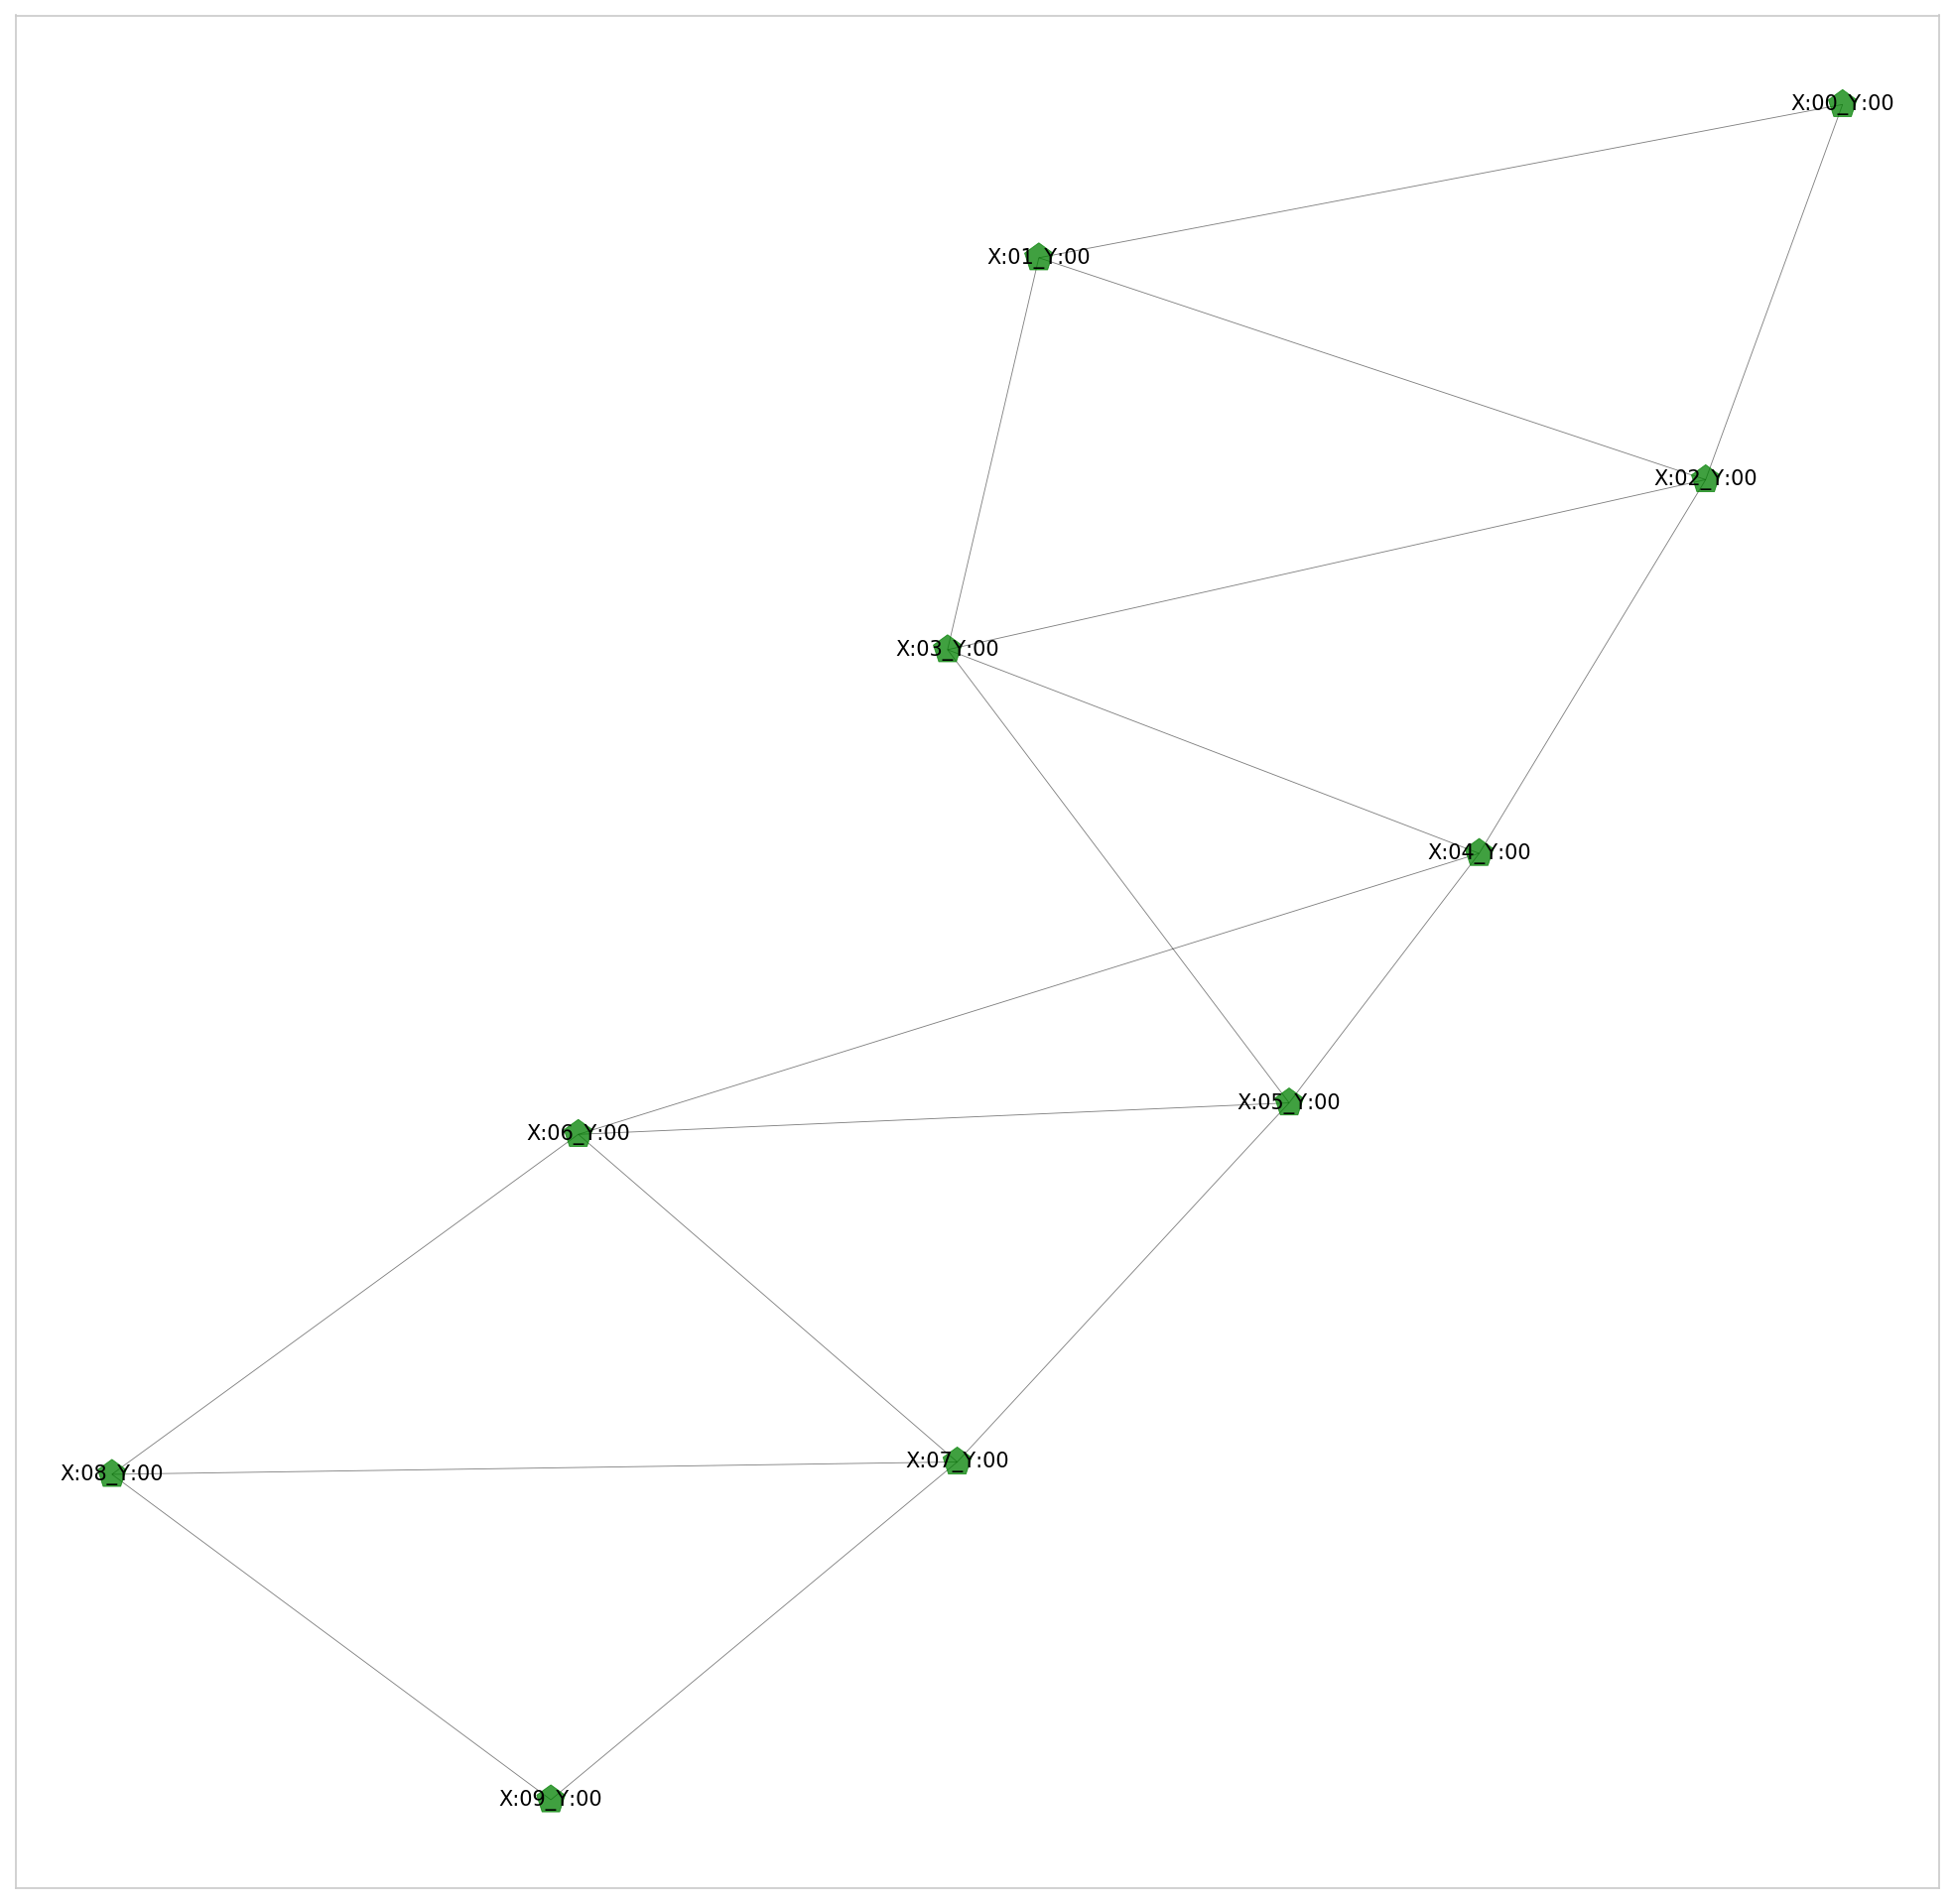

In [10]:
G = nx.from_scipy_sparse_matrix(adj[:10, :10])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
draw_graph_mpl(G);

- Show 12 rows of the network

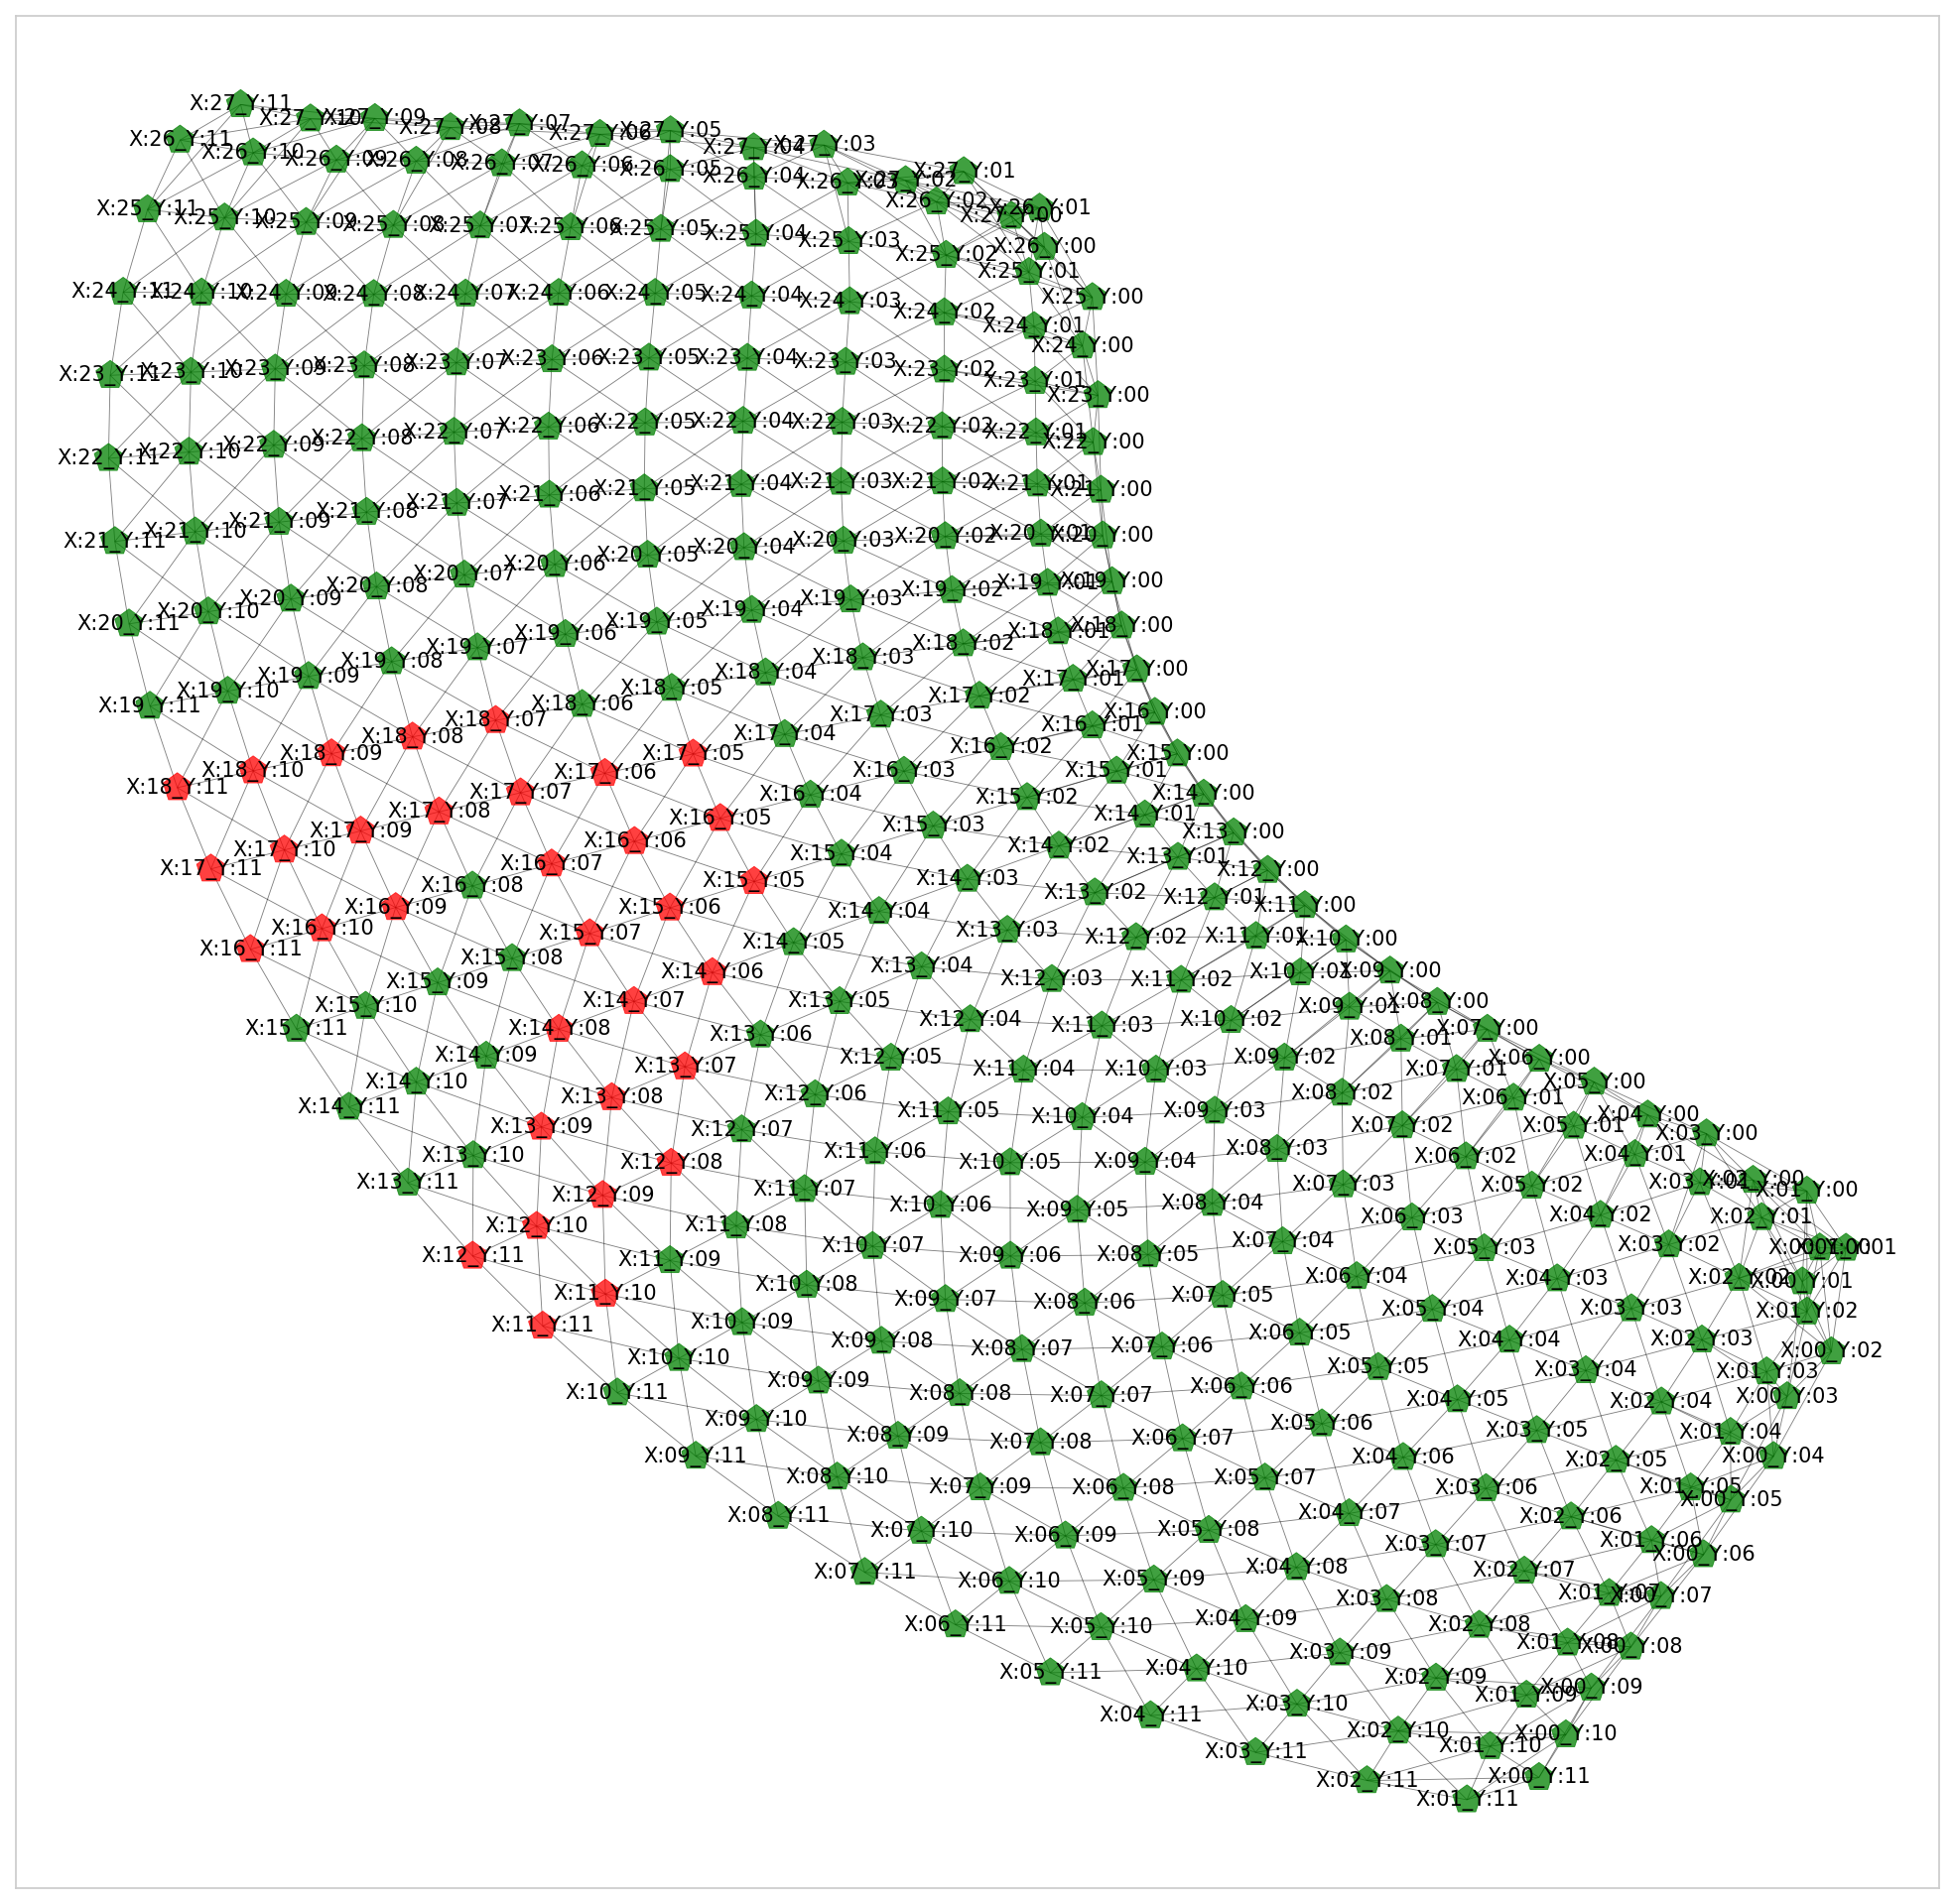

In [11]:
MAX_NODE = 28*12
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G);

- Show network (using the X, Y coordinates)

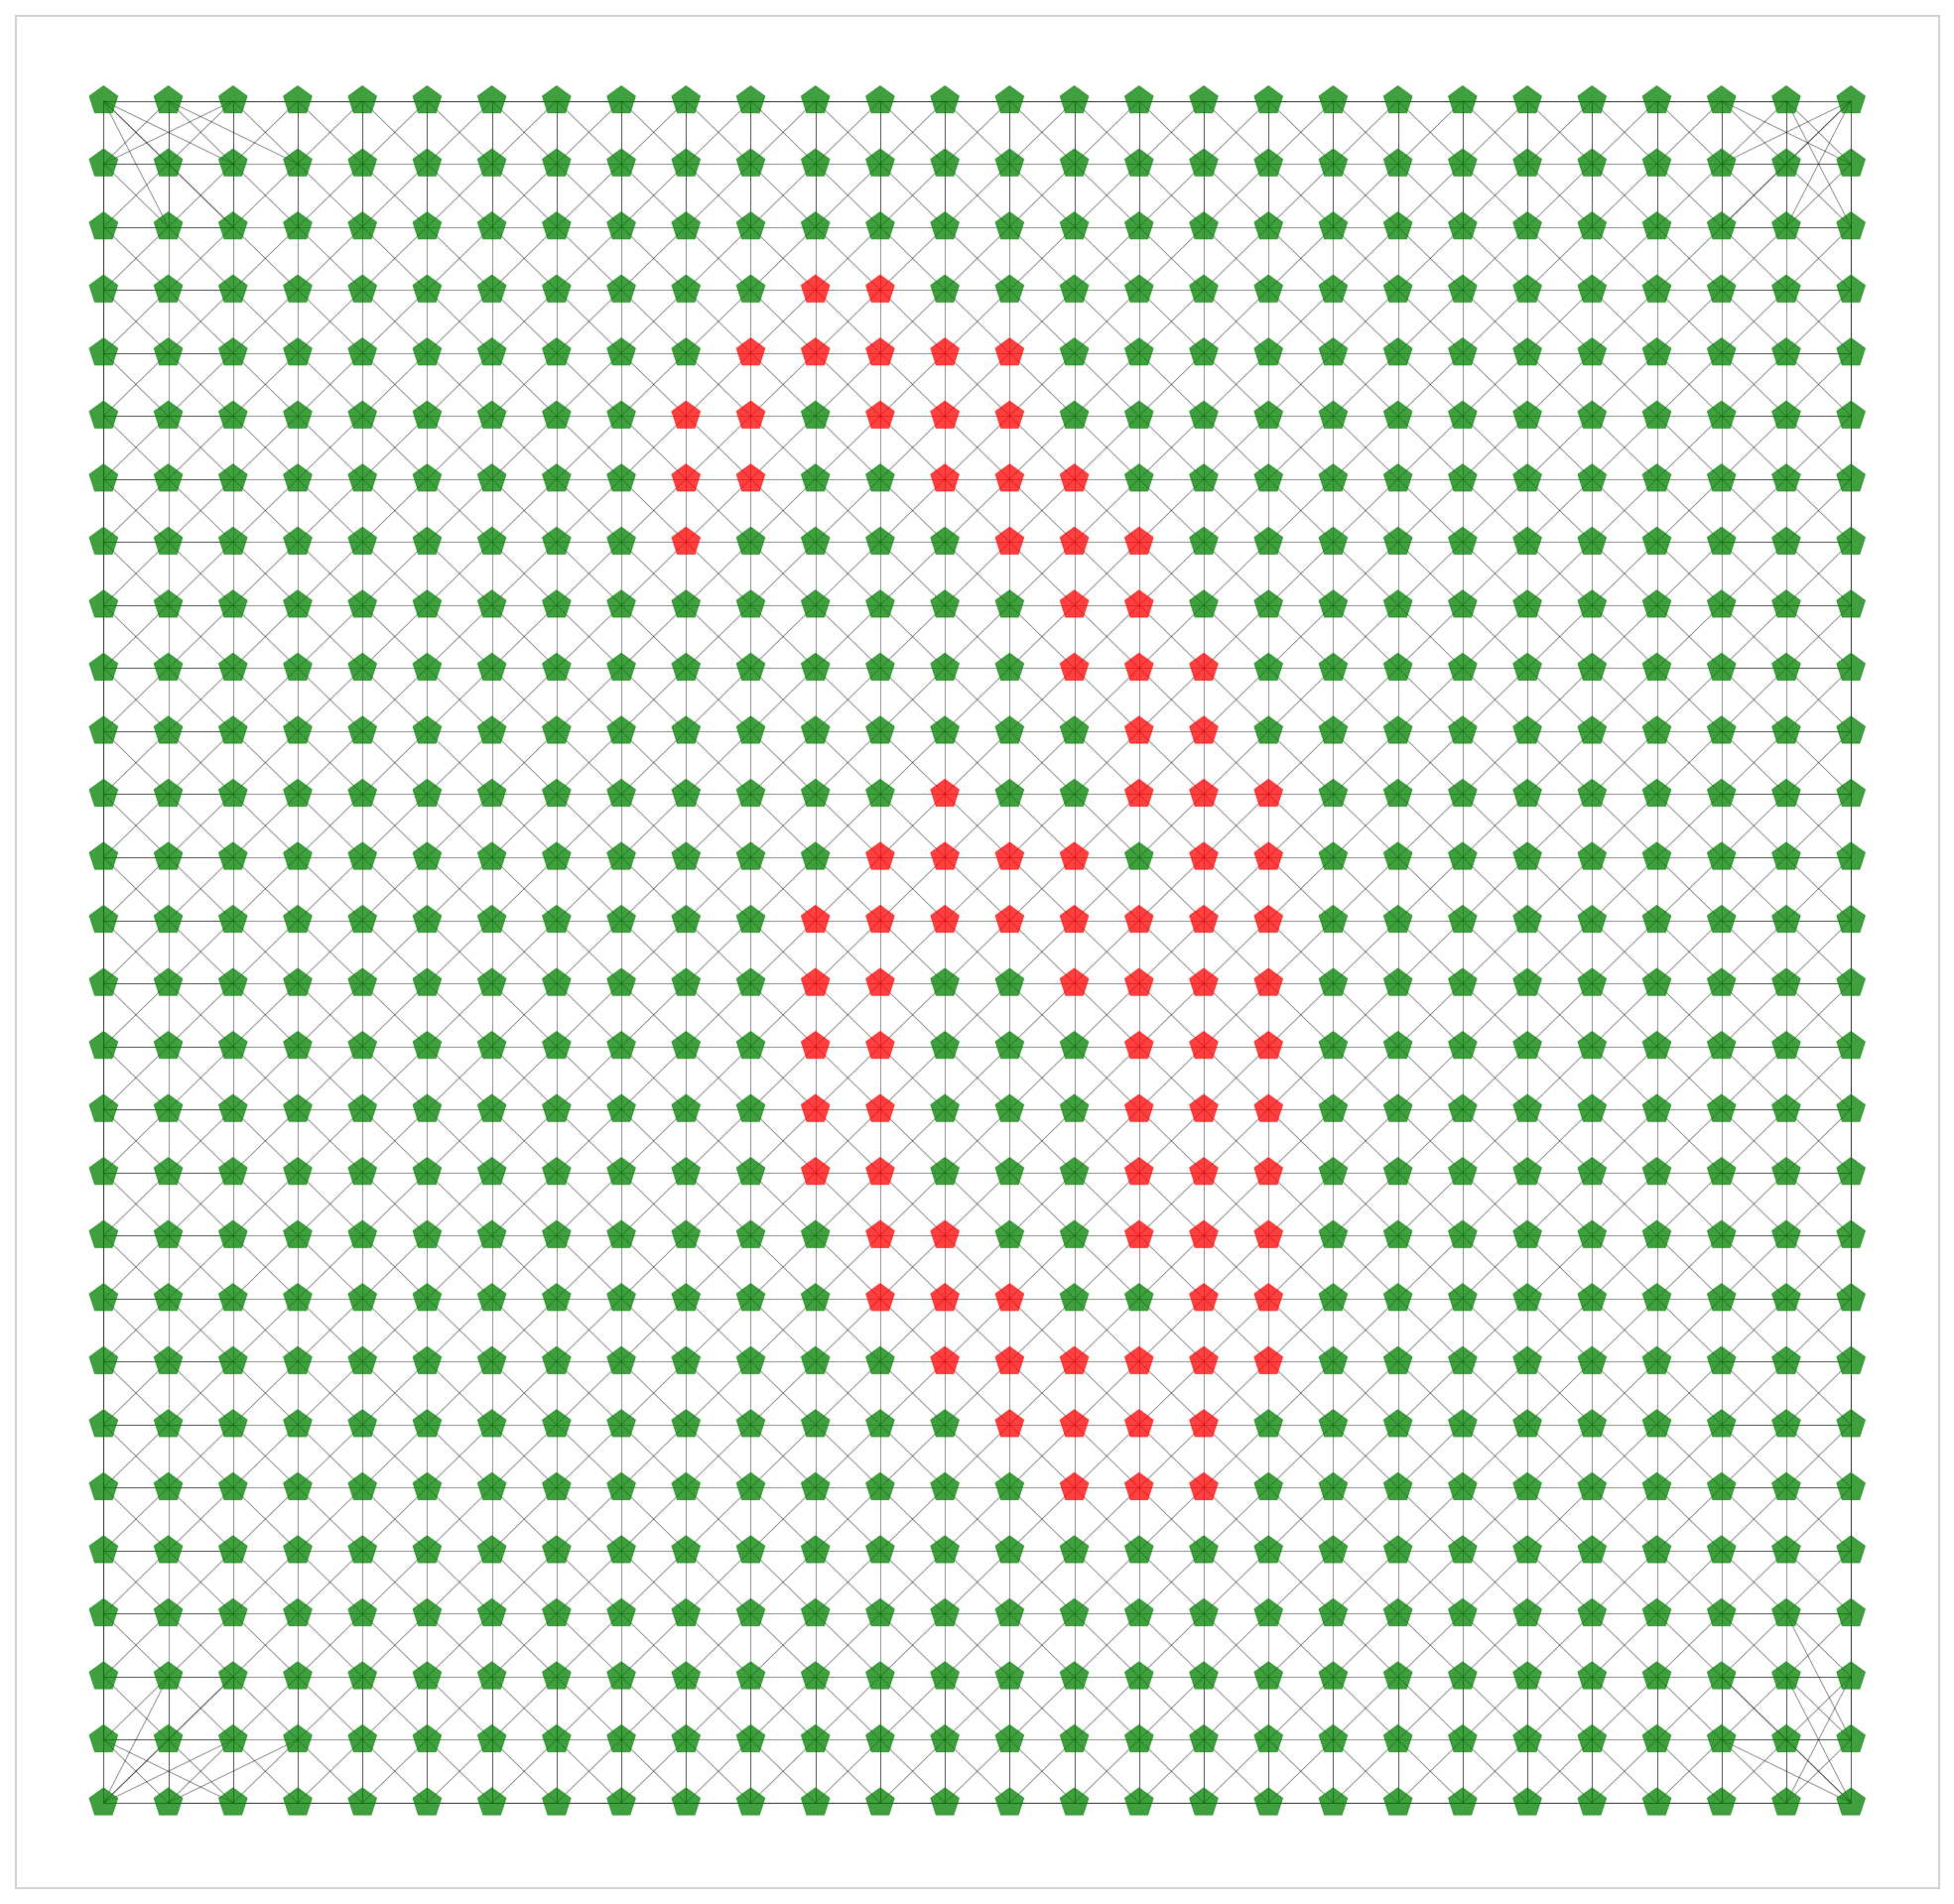

In [12]:
G = nx.from_scipy_sparse_matrix(adj)
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = ''
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));

# Model Building
Now we can build the model which uses the graph topology shown above as the basis. We feed the topology in as a constant tensor ($A_{in}$) and the convolutions occur across this topology. 

In [13]:
fltr = normalized_laplacian(adj)

# Model definition
X_in = Input(shape=(N, F))
# Pass A as a fixed tensor, otherwise Keras will complain about inputs of
# different rank.
A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

graph_conv_1 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([X_in, A_in])
graph_conv_2 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([graph_conv_1, A_in])
flatten = Flatten()(graph_conv_2)
fc = Dense(512, activation='relu')(flatten)
output = Dense(n_out, activation='softmax')(fc)

# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 784, 32)      64          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 784, 32)      1056        graph_conv_1[0][0]         

In [14]:
# Train model
validation_data = (X_val, y_val)
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
          callbacks=[
              EarlyStopping(patience=es_patience, restore_best_weights=True)
          ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 404s 8ms/step - loss: 0.6047 - acc: 0.8151 - val_loss: 0.3602 - val_acc: 0.8948
Epoch 2/5
50000/50000 [==============================] - 402s 8ms/step - loss: 0.2088 - acc: 0.9370 - val_loss: 0.3554 - val_acc: 0.8994
Epoch 3/5
50000/50000 [==============================] - 400s 8ms/step - loss: 0.1187 - acc: 0.9641 - val_loss: 0.4027 - val_acc: 0.9001
Epoch 4/5
50000/50000 [==============================] - 398s 8ms/step - loss: 0.0858 - acc: 0.9746 - val_loss: 0.4590 - val_acc: 0.9023
Epoch 5/5
50000/50000 [==============================] - 401s 8ms/step - loss: 0.0665 - acc: 0.9806 - val_loss: 0.4201 - val_acc: 0.9090


In [15]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

Evaluating model.
10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.40789844468832015
Test acc: 0.9135


# What did the model actually learn?
We can now try and reassemble what the model actually learnt by exporting the intermediate layers

# Weights
Not sure exactly how to interpret these but we can show them easily enough

(1, 32) (32,)


<BarContainer object of 32 artists>

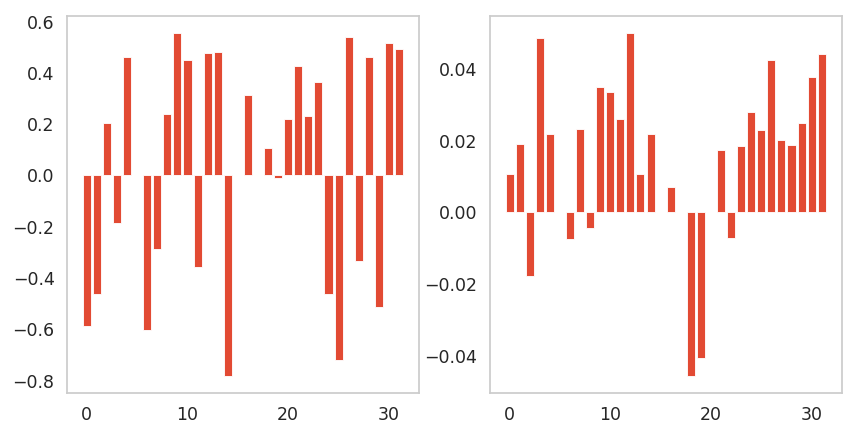

In [16]:
W, b = model.layers[2].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.bar(np.arange(W.shape[1]), W[0])
ax2.bar(np.arange(W.shape[1]), b)

(32, 32) (32,)


<BarContainer object of 32 artists>

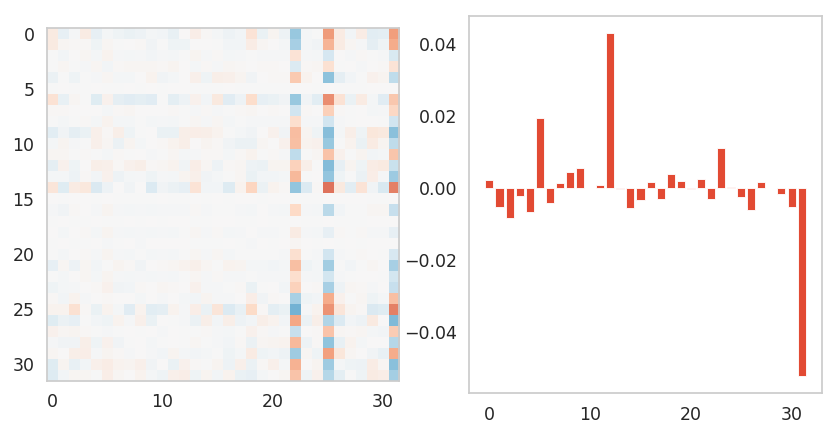

In [17]:
W, b = model.layers[3].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

## Show intermediate output values
Here we can rearrange the output of the graph convolutions to see if the model is learning similar sorts of features to the standard convolutional neural networks

In [18]:
i_model = Model(inputs=[X_in, A_in], outputs=[graph_conv_1, graph_conv_2])

In [19]:
gc1_out, gc2_out = i_model.predict(X_test[:32])

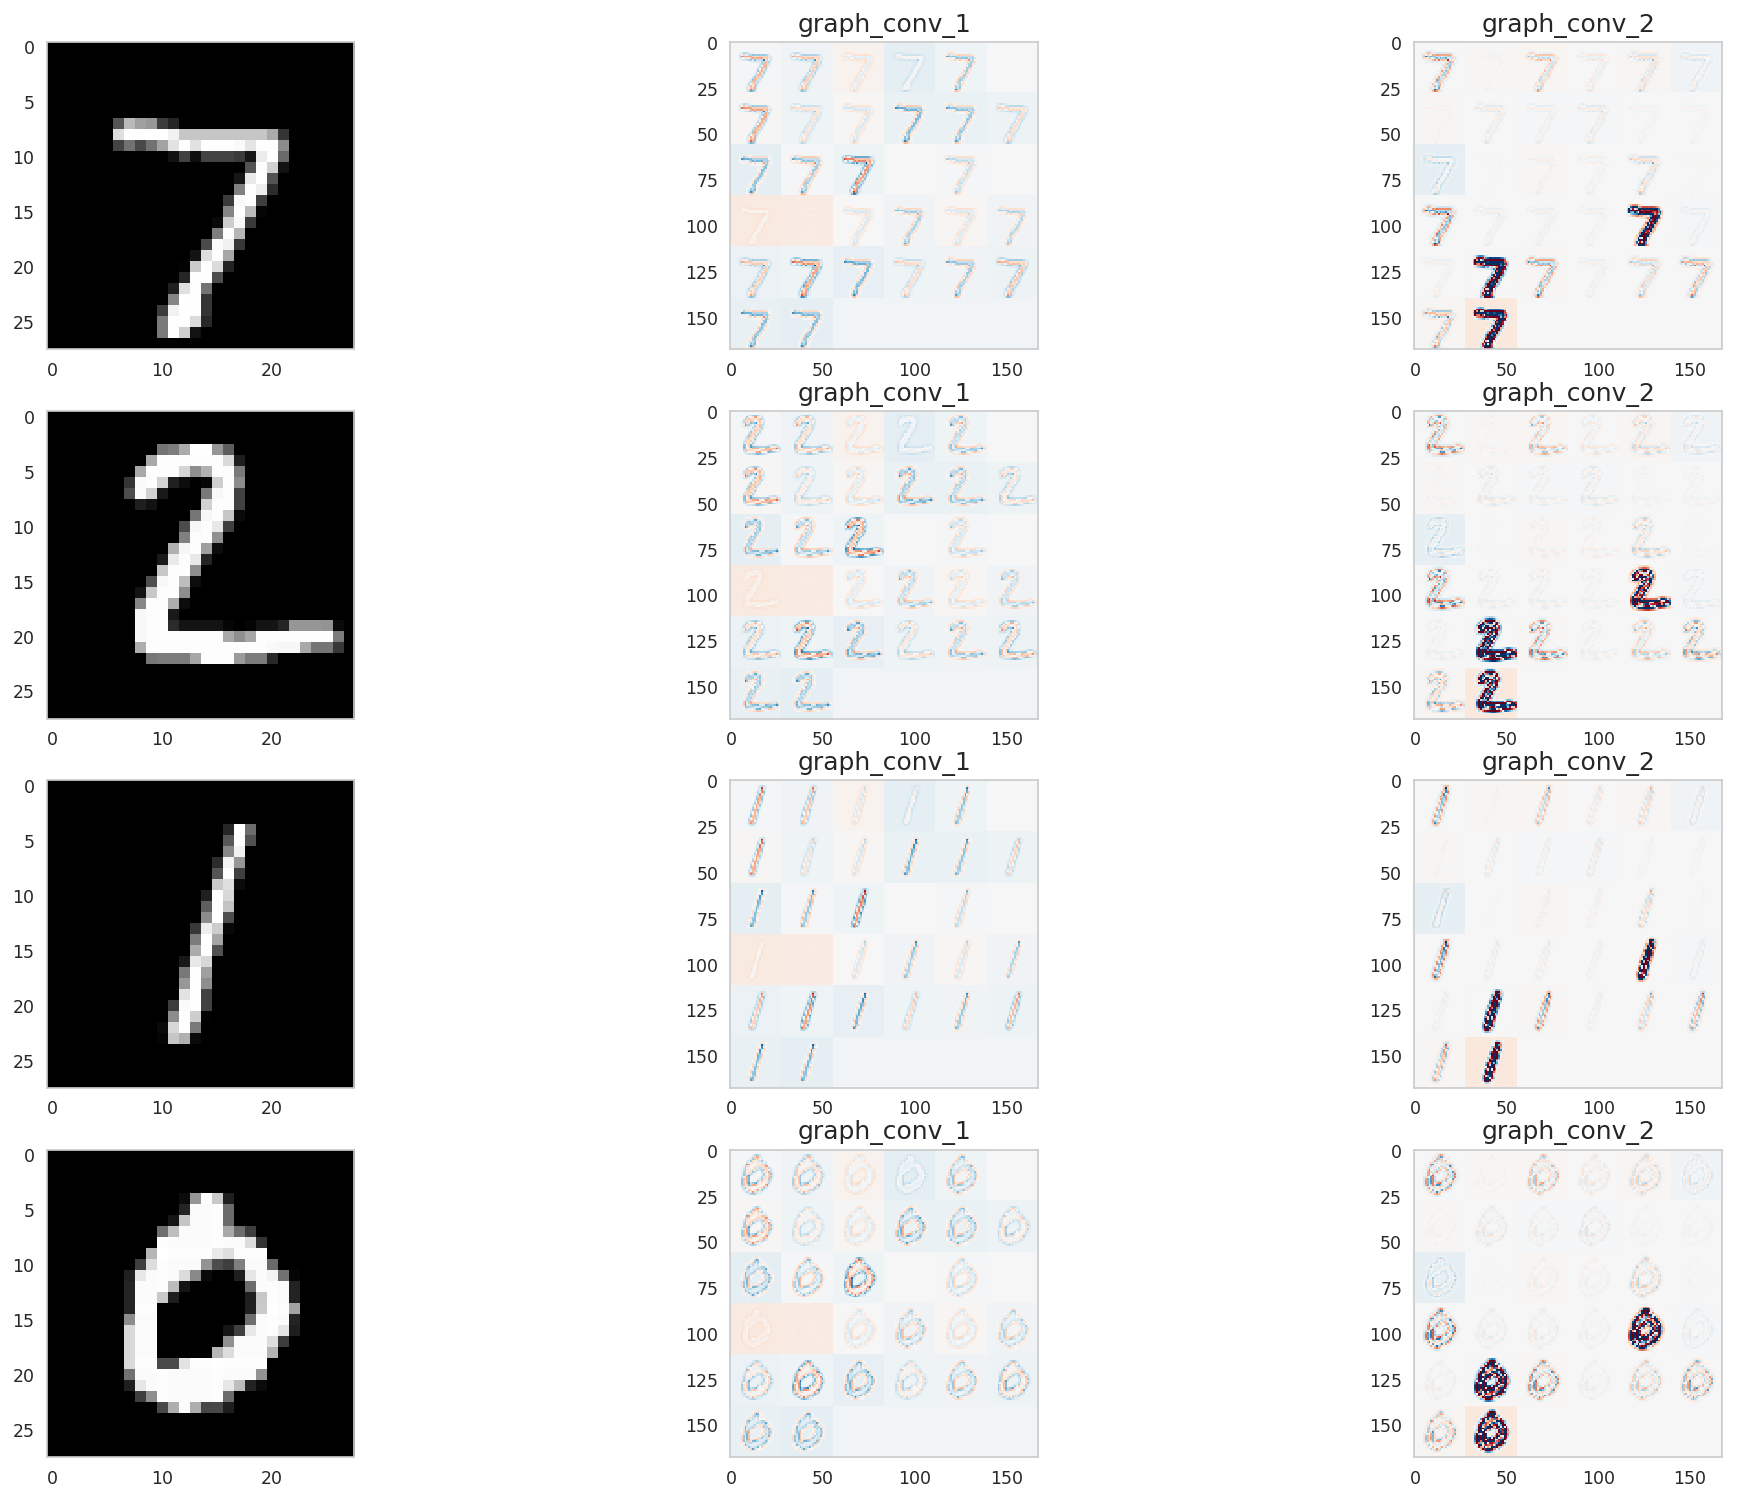

In [20]:
fig, m_axs = plt.subplots(4, 3, figsize=(20, 15))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(X_test[i].reshape((28, 28)))
    gc_stack = gc1_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax2.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax2.set_title(i_model.output_names[0])
    gc_stack = gc2_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax3.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax3.set_title(i_model.output_names[1])